### Understanding Girvan-Newman Assortiative Mixing Model

In [164]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Get the edge count from the mixing matrix and the poisson coeffients. Set the seed to a fixed value so that you get the same number each time.

In [165]:
%autoreload 2

from Girvan_Newman_stochastic_block_network_v3 import AssortativeMixing
import numpy as np
from numpy.typing import NDArray


M: NDArray[np.float32] = np.array([[0.4, 0.01],
                                   [0.01, 0.4]]) 
poisson_lambda: list[int] = [6, 4]
num_edges: int = 50
seed =42

assortative_network: AssortativeMixing = AssortativeMixing(M, poisson_lambda)


In [166]:
edge_count_by_type = assortative_network._draw_edges_from_mixing_matrix(M, num_edges, seed=seed)
print(edge_count_by_type)

{(0, 0): 25, (0, 1): 2, (1, 0): 1, (1, 1): 22}


Count the number of stubs of each type required. There should be 
- type 0: 21*2 + 4 + 6 = 52
- type 1: 4 + 6 + 2*19 = 48

In [167]:
num_classes: int = len(M)
stubs_per_class = assortative_network._get_number_of_stubs_per_class(edge_count_by_type, num_classes)
print(stubs_per_class)

{0: 53, 1: 47}


Generate nodes of each type with degree randomly drawn from a Poisson distribution. Seed the distribution so that results are replicable. The number of nodes of each type is determined by dividing the number of stubs of each class by the average degree of nodes in the class. We're using a Poisson distribution for node degree so the average node degree is lambda. 

We expect that the number of nodes is
- class 0 is  52/6 rounded up, which is 9 
- class 1 is 48/4 = 12

In [168]:
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                    poisson_lambda[node_class])
    print(f"number of nodes of class {node_class} is {num_required_nodes}")

number of nodes of class 0 is 9
number of nodes of class 1 is 12


generate a list of nodes with a fixed seed for each class and add the list to a dictionary indexed by class

In [169]:
starting_node_id: int = 0
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                    poisson_lambda[node_class])
    node_list = assortative_network._create_nodes_for_class(node_class,
                                                  num_required_nodes,
                                                  poisson_lambda[node_class],
                                                  starting_node_id,
                                                  seed=seed)
    print(f"node list for class {node_class} is:")
    print(f"   {[node.ID for node in node_list]}")
    print("which have degrees")
    print(f"   {[node.degree for node in node_list]}")
    print("and difference between required stubs and actual stubs of ")
    print(f"   {stubs_per_class[node_class]} - {sum([node.degree for node in node_list])}")
    starting_node_id += len(node_list)

node list for class 0 is:
   [0, 1, 2, 3, 4, 5, 6, 7, 8]
which have degrees
   [6, 6, 4, 5, 4, 6, 4, 4, 9]
and difference between required stubs and actual stubs of 
   53 - 48
node list for class 1 is:
   [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
which have degrees
   [5, 4, 4, 4, 2, 5, 2, 5, 3, 5, 7, 1]
and difference between required stubs and actual stubs of 
   47 - 47


Resample degree until required number of stubs equals actual stubs

In [170]:
starting_node_id = 0
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                    poisson_lambda[node_class])
    node_list = assortative_network._create_nodes_for_class(node_class,
                                                  num_required_nodes,
                                                  poisson_lambda[node_class],
                                                  starting_node_id,
                                                  seed=seed)
    node_list = assortative_network._resample_node_degrees_in_nodelist(node_list,
                                                                       stubs_per_class[node_class],
                                                                       poisson_lambda[node_class],
                                                                       seed=seed)
    starting_node_id += len(node_list)
    print(f"node list for class {node_class} is:")
    print(f"   {[node.ID for node in node_list]}")
    print("which have degrees")
    print(f"   {[node.degree for node in node_list]}")
    print("and difference between required stubs and actual stubs of ")
    print(f"   {stubs_per_class[node_class]} - {sum([node.degree for node in node_list])}")

node list for class 0 is:
   [0, 1, 2, 3, 4, 5, 6, 7, 8]
which have degrees
   [8, 6, 3, 9, 8, 6, 4, 4, 5]
and difference between required stubs and actual stubs of 
   53 - 53
node list for class 1 is:
   [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
which have degrees
   [5, 4, 4, 4, 2, 5, 2, 5, 3, 5, 7, 1]
and difference between required stubs and actual stubs of 
   47 - 47


Make sure that the dictionary of nodelists of each time is populated

In [171]:
from Girvan_Newman_stochastic_block_network_v3 import Node_Type
starting_node_id = 0
all_nodes: list[Node_Type] = []
for node_class in stubs_per_class.keys():
    num_required_nodes = assortative_network._get_number_nodes_in_class(stubs_per_class[node_class],
                                                                        poisson_lambda[node_class])
    node_list = assortative_network._create_nodes_for_class(node_class,
                                                  num_required_nodes,
                                                  poisson_lambda[node_class],
                                                  starting_node_id,
                                                  seed=seed)
    node_list = assortative_network._resample_node_degrees_in_nodelist(node_list,
                                                                       stubs_per_class[node_class],
                                                                       poisson_lambda[node_class],
                                                                       seed=seed)
    all_nodes.extend(node_list)
    starting_node_id += len(node_list)
for node in all_nodes:
    print(f"node {node.ID} has node degrees {node.degree}")

node 0 has node degrees 8
node 1 has node degrees 6
node 2 has node degrees 3
node 3 has node degrees 9
node 4 has node degrees 8
node 5 has node degrees 6
node 6 has node degrees 4
node 7 has node degrees 4
node 8 has node degrees 5
node 9 has node degrees 5
node 10 has node degrees 4
node 11 has node degrees 4
node 12 has node degrees 4
node 13 has node degrees 2
node 14 has node degrees 5
node 15 has node degrees 2
node 16 has node degrees 5
node 17 has node degrees 3
node 18 has node degrees 5
node 19 has node degrees 7
node 20 has node degrees 1


Now check that the function that does all these steps returns the same thing.

In [172]:
all_nodes = assortative_network._create_nodes(stubs_per_class, 
                                                        poisson_lambda,
                                                        seed=seed)
for node in all_nodes:
    print(f"node {node.ID} has node degrees {node.degree}")

node 0 has node degrees 8
node 1 has node degrees 6
node 2 has node degrees 3
node 3 has node degrees 9
node 4 has node degrees 8
node 5 has node degrees 6
node 6 has node degrees 4
node 7 has node degrees 4
node 8 has node degrees 5
node 9 has node degrees 5
node 10 has node degrees 4
node 11 has node degrees 4
node 12 has node degrees 4
node 13 has node degrees 2
node 14 has node degrees 5
node 15 has node degrees 2
node 16 has node degrees 5
node 17 has node degrees 3
node 18 has node degrees 5
node 19 has node degrees 7
node 20 has node degrees 1


---

### Adding Edges

**Step 1: Create spanning tree of all nodes:**  This ensures that the graph returned by the algorithm is connected.

Randomly choose nodes to add to the spanning tree and connect them to nodes in the current tree, with the constraint that there must be an edge_type in the "budget" specified by the edge_count_by_type

In [173]:
import random
random.seed(seed)
free_stubs_in_tree: list[Node_Type] = []
nodes_not_in_tree: set[Node_Type] = set(all_nodes)

def get_rootnode(node_list: list[Node_Type]) -> Node_Type:
    # Choose root node randomly with the constraint that it can't have degree 1
    root_node: Node_Type = random.choice(node_list)
    while root_node.degree < 2:
        root_node = random.choice(node_list)
        print("In loop looking for node with degree 2 or more")
        print(f"root node degree = {root_node.degree}")
    return root_node

# Initalize tree
root_node = get_rootnode(all_nodes)
# Add copies into tree, one copy for each stub
free_stubs_in_tree.extend([root_node for _ in range(root_node.degree)])
nodes_not_in_tree.remove(root_node)
print([node.ID for node in free_stubs_in_tree])


In loop looking for node with degree 2 or more
root node degree = 9
[3, 3, 3, 3, 3, 3, 3, 3, 3]


Move this into a function

In [174]:
def initialize_tree(node_list: list[Node_Type]
                    ) -> tuple[list[Node_Type], set[Node_Type]]:
    free_stubs_in_tree: list[Node_Type] = []
    nodes_not_in_tree: set[Node_Type] = set(node_list)
    root_node = get_rootnode(node_list)
    # Add copies into tree, one copy for each stub
    free_stubs_in_tree.extend([root_node for _ in range(root_node.degree)]) 
    nodes_not_in_tree.remove(root_node)
    return free_stubs_in_tree, nodes_not_in_tree

Add nodes not in the tree to a node in the tree subject to the constraint that there is an edge of the correct type still to allocate

In [175]:
from copy import deepcopy
def pair_nodes(free_stubs_in_tree: list[Node_Type], 
               nodes_not_in_tree: set[Node_Type],
               edge_count_by_type: dict[tuple[int,int], int]
               ) -> tuple[Node_Type, Node_Type]:   
    node1: Node_Type = random.choice(free_stubs_in_tree)
    node2: Node_Type = random.choice(list(nodes_not_in_tree))
    while edge_count_by_type[(node1.node_type, node2.node_type)] == 0:
        node1 = random.choice(free_stubs_in_tree)
        node2 = random.choice(list(nodes_not_in_tree))
    return node1, node2

edge_list: list[tuple[Node_Type,Node_Type]] = []
edge_count_by_type_copy = deepcopy(edge_count_by_type)
while len(nodes_not_in_tree) > 0 and len(free_stubs_in_tree) > 0:
    # find nodes to join and add edge
    node1, node2 = pair_nodes(free_stubs_in_tree, nodes_not_in_tree, edge_count_by_type)
    edge_list.append((node1, node2))

    # update counts
    # Add copies into tree, one copy for each stub
    free_stubs_in_tree.extend([node2 for _ in range(node2.degree-1)]) 
    free_stubs_in_tree.remove(node1)
    nodes_not_in_tree.remove(node2)
    
    edge_count_by_type_copy[(node1.node_type, node2.node_type)] -= 1


    print(f"free tree nodes = {[node.ID for node in free_stubs_in_tree]}")
    print(f"remaining nodes = {[node.ID for node in nodes_not_in_tree]}")
    


free tree nodes = [3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0]
remaining nodes = [6, 13, 20, 16, 5, 8, 15, 12, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
free tree nodes = [3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12]
remaining nodes = [6, 13, 20, 16, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
free tree nodes = [3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 16, 16, 16, 16]
remaining nodes = [6, 13, 20, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
free tree nodes = [3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 16, 16, 16]
remaining nodes = [6, 13, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
free tree nodes = [3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 16, 16, 7, 7, 7]
remaining nodes = [6, 13, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 10, 9]
free tree nodes = [3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 16, 16, 7, 7, 7, 6, 6, 6]
remaining nodes = [13, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 10, 9]
free tree nodes = [3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0

Let's pull the updates to the set and list into functions

In [176]:
def update_free_stubs_in_tree(node1: Node_Type,
                              node2: Node_Type,
                              free_stubs_in_tree: list[Node_Type],
                              ) -> list[Node_Type]:
    # Add copies into tree, one copy for each stub
    free_stubs_in_tree.extend([node2 for _ in range(node2.degree-1)]) 
    free_stubs_in_tree.remove(node1)
    return free_stubs_in_tree

def update_nodes_not_in_tree(node: Node_Type,
                             nodes_not_in_tree: set[Node_Type]
                             ) -> set[Node_Type]:
    nodes_not_in_tree.remove(node)
    return nodes_not_in_tree

In [177]:
random.seed(seed)
free_stubs_in_tree, nodes_not_in_tree = initialize_tree(all_nodes)
print("**** initialize ****")
print(f"free stubs = {[node.ID for node in free_stubs_in_tree]}")
print(f"nodes not in tree = {[node.ID for node in nodes_not_in_tree]}")
print("********************\n")


edge_list: list[tuple[Node_Type,Node_Type]] = []
edge_count_by_type_copy = deepcopy(edge_count_by_type)
while len(nodes_not_in_tree) > 0 and len(free_stubs_in_tree) > 0:
    # find nodes to join and add edge
    node1, node2 = pair_nodes(free_stubs_in_tree, nodes_not_in_tree, edge_count_by_type_copy)
    edge_list.append((node1, node2))
    print(f"add edge from node {node1.ID} to node {node2.ID}")

    # update counts
    free_stubs_in_tree = update_free_stubs_in_tree(node1, node2, free_stubs_in_tree)
    nodes_not_in_tree = update_nodes_not_in_tree(node2, nodes_not_in_tree)
    
    # update copy of edge counter
    edge_count_by_type_copy[(node1.node_type, node2.node_type)] -= 1

    print(f"free stubs = {[node.ID for node in free_stubs_in_tree]}")
    print(f"remaining nodes = {[node.ID for node in nodes_not_in_tree]}")
    

In loop looking for node with degree 2 or more
root node degree = 9
**** initialize ****
free stubs = [3, 3, 3, 3, 3, 3, 3, 3, 3]
nodes not in tree = [6, 13, 20, 16, 5, 8, 15, 12, 0, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
********************

add edge from node 3 to node 0
free stubs = [3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0]
remaining nodes = [6, 13, 20, 16, 5, 8, 15, 12, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
add edge from node 3 to node 12
free stubs = [3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12]
remaining nodes = [6, 13, 20, 16, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
add edge from node 3 to node 16
free stubs = [3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 16, 16, 16, 16]
remaining nodes = [6, 13, 20, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
add edge from node 16 to node 20
free stubs = [3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 12, 12, 12, 16, 16, 16]
remaining nodes = [6, 13, 5, 8, 15, 1, 2, 14, 19, 4, 17, 18, 11, 7, 10, 9]
add edge from node 

Check out the list of edges and the length of this list

In [178]:
for edge in edge_list:
    print(f"edge between node {edge[0].ID} and {edge[1].ID}")
print(f"there are {len(edge_list)} edges and {len(all_nodes)} nodes")

edge between node 3 and 0
edge between node 3 and 12
edge between node 3 and 16
edge between node 16 and 20
edge between node 16 and 7
edge between node 3 and 6
edge between node 0 and 4
edge between node 12 and 15
edge between node 16 and 11
edge between node 4 and 8
edge between node 11 and 19
edge between node 6 and 1
edge between node 16 and 18
edge between node 15 and 13
edge between node 1 and 2
edge between node 2 and 5
edge between node 18 and 10
edge between node 18 and 17
edge between node 19 and 14
edge between node 11 and 9
there are 20 edges and 21 nodes


Move these steps into a function

In [179]:
def get_edges_from_spanning_tree(edge_count_by_type: dict[tuple[int, int], int],
                                 node_list: list[Node_Type]
                                 ) -> list[tuple[Node_Type,Node_Type]]:

    free_stubs_in_tree, nodes_not_in_tree = initialize_tree(node_list)

    edge_list: list[tuple[Node_Type,Node_Type]] = []
    edge_count_by_type_copy = deepcopy(edge_count_by_type)
    while len(nodes_not_in_tree) > 0 and len(free_stubs_in_tree) > 0:
        # find nodes to join and add edge
        node1, node2 = pair_nodes(free_stubs_in_tree, nodes_not_in_tree, edge_count_by_type_copy)
        edge_list.append((node1, node2))

        # update counts
        free_stubs_in_tree = update_free_stubs_in_tree(node1, node2, free_stubs_in_tree)
        nodes_not_in_tree = update_nodes_not_in_tree(node2, nodes_not_in_tree)
        
        # update copy of edge counter
        edge_count_by_type_copy[(node1.node_type, node2.node_type)] -= 1

    return edge_list


In [180]:
random.seed(seed)
edge_count_by_type_copy = deepcopy(edge_count_by_type)
edge_list = get_edges_from_spanning_tree(edge_count_by_type_copy, all_nodes)
for edge in edge_list:
    print(f"edge between node {edge[0].ID} and {edge[1].ID}")
print(f"there are {len(edge_list)} edges and {len(all_nodes)} nodes")


In loop looking for node with degree 2 or more
root node degree = 9
edge between node 3 and 0
edge between node 3 and 12
edge between node 3 and 16
edge between node 16 and 20
edge between node 16 and 7
edge between node 3 and 6
edge between node 0 and 4
edge between node 12 and 15
edge between node 16 and 11
edge between node 4 and 8
edge between node 11 and 19
edge between node 6 and 1
edge between node 16 and 18
edge between node 15 and 13
edge between node 1 and 2
edge between node 2 and 5
edge between node 18 and 10
edge between node 18 and 17
edge between node 19 and 14
edge between node 11 and 9
there are 20 edges and 21 nodes


In [181]:
random.seed(seed)
while True:
    # There is a chance that the spanning tree algorithm will terminate
    # before all nodes make it into the tree just because of bad luck
    # That chance should be small, so if it happens try a new tree
    edge_count_by_type_copy = deepcopy(edge_count_by_type)
    
    edge_list = get_edges_from_spanning_tree(edge_count_by_type_copy, 
                                             all_nodes)
    if len(edge_list) == len(all_nodes) - 1: #spanning trees have one fewer edge than nodes
        break

In loop looking for node with degree 2 or more
root node degree = 9


Inspect output

In [182]:
for edge in edge_list:
    print(f"edge between node {edge[0].ID} and {edge[1].ID}")
print(f"there are {len(edge_list)} edges and {len(all_nodes)} nodes")

edge between node 3 and 0
edge between node 3 and 12
edge between node 3 and 16
edge between node 16 and 20
edge between node 16 and 7
edge between node 3 and 6
edge between node 0 and 4
edge between node 12 and 15
edge between node 16 and 11
edge between node 4 and 8
edge between node 11 and 19
edge between node 6 and 1
edge between node 16 and 18
edge between node 15 and 13
edge between node 1 and 2
edge between node 2 and 5
edge between node 18 and 10
edge between node 18 and 17
edge between node 19 and 14
edge between node 11 and 9
there are 20 edges and 21 nodes


Now try from withing the function

In [183]:
edge_list = assortative_network._add_edges(all_nodes,
                                           edge_count_by_type,
                                           all_nodes,
                                           seed=seed)
for edge in edge_list:
    print(f"edge between node {edge[0].ID} and {edge[1].ID}")
print(f"there are {len(edge_list)} edges and {len(all_nodes)} nodes")

KeyboardInterrupt: 

---

Show tree to see if it makes sense

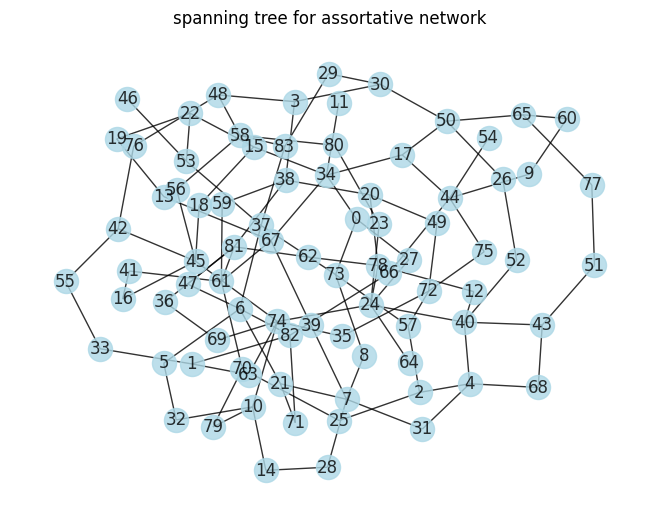

In [ ]:
from drawing_utilities import show_graph
from drawing_utilities import show_dendrogram
from drawing_utilities import show_partitions
show_graph(assortative_network.G, title="spanning tree for assortative network")

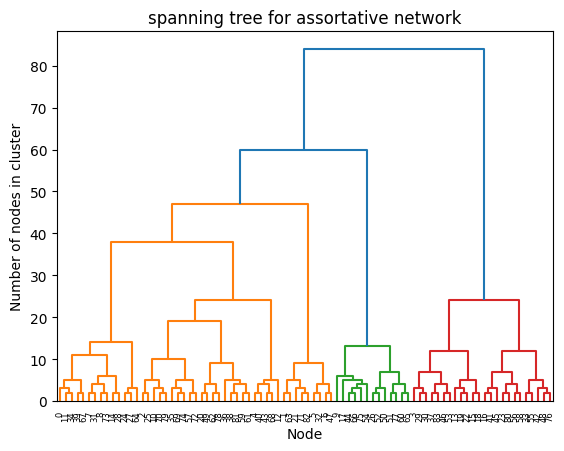

In [ ]:
show_dendrogram(assortative_network.G, title="spanning tree for assortative network")

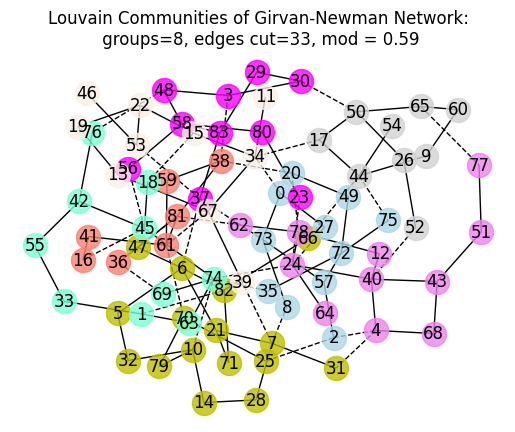

In [ ]:
import networkx as nx
partitions = nx.community.louvain_communities(assortative_network.G, seed=42)
show_partitions(assortative_network.G, 
                partition=partitions, 
                title="Louvain Communities of Girvan-Newman Network:\n")

---

### Add remaining edges

In [ ]:
edge_count_by_type = deepcopy(edge_count_by_type_copy)
edge_type_list: list[tuple[int,int]] = []
for edge_type, count in edge_count_by_type.items():
    edge_type_list.extend([edge_type for _ in range(count)])
random.seed(seed)
random.shuffle(edge_type_list)
print(edge_type_list)

[(1, 0), (0, 1), (0, 0), (0, 0), (0, 0), (1, 1), (1, 0), (0, 0), (1, 0), (0, 0), (1, 1), (0, 1), (0, 0), (0, 0), (1, 1), (1, 1), (0, 0), (0, 1), (1, 1), (0, 0), (1, 1), (0, 0), (1, 1), (1, 1), (1, 1), (1, 0), (1, 0), (0, 0), (0, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (0, 0), (1, 1), (1, 1), (0, 0), (1, 0), (1, 1), (0, 0), (1, 1), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (1, 1)]


In [ ]:
while len(edge_type_list) > 0:
    edge: tuple[Node_Type, Node_Type] = edge_list[0]
    free_stubs_matching_edge0: list[Node_Type] = [node for node in free_stubs_in_tree if node.node_type == edge[0].node_type]
    free_stubs_matching_edge1: list[Node_Type] = [node for node in free_stubs_in_tree if node.node_type == edge[1].node_type]
    if len(free_stubs_matching_edge0) == 0 or len(free_stubs_matching_edge1) == 0:
        print(f"Unable to find stubs to add edge from node {edge[0].ID} to node {edge[1].ID}")
    else:
        node1: Node_Type = random.choice(free_stubs_matching_edge0)
        node2: Node_Type = random.choice(free_stubs_matching_edge1)
        edge_list.append((node1, node2))
        free_stubs_in_tree.remove(node1)
        free_stubs_in_tree.remove(node2)
    edge_list = edge_list[1:]

for edge in edge_list:
    print(f"edge from node {edge[0].ID} to node {edge[1].ID}")

ValueError: list.remove(x): x not in list